# Wprowadzenie - o wskazniku MACD
Wskaznik MACD uzywany jest do badania sygnalow kupna i sprzedazy akcji.
Sklada sie z dwoch linii: MACD oraz SIGNAL. Linie MACD wyznacza sie,
jako roznice dwóch srednich kroczacych cen akcji sprzed 26 i 12 dni.
Linia SIGNAL to srednia kroczaca wyznaczona na podstawie wartosci MACD, 
z 9 ostatnich dni. W projekcie sprawdzono zyskownosc stosowania wskaznika,
dla firm z ogolna tendencja spadkowa, jak i wzrostowa.

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from datetime import datetime
from datetime import timedelta
import pandas_datareader as web

# Funkcje pobierajace dane i formatujace plik
Pobranie historycznych danych, ze strony yahoo finance,
oraz zapisanie ich w formacie csv. Nastepnie sformatowanie pliku,
aby zostaly tylko kluczowe kolumny tj. daty i ceny zamkniecia

In [6]:
def download_stock_prices(company_name,start_year, start_month,
                          start_day, end_year, end_month, end_day):
    start = datetime(start_year, start_month, start_day)
    end = datetime(end_year,end_month,end_day)
    df = web.DataReader(company_name, 'yahoo', start, end)
    df.to_csv(company_name + '.csv')
    return company_name + '.csv'

def open_file_and_format(file_name):
    data_frame = pd.read_csv(file_name)
    data_frame.drop(["High", "Low", "Open", "Volume", "Adj Close"],
                    axis = 1, inplace = True)
    data_frame.rename(columns={'Date': 'Date', 'Close': 'Value'}, inplace=True)
    return data_frame

# Funkcje liczace wartosci MACD oraz SIGNAL
Uzywajac funkcji liczacej srednia kroczaca, liczenie wskaznika MACD,
poczawszy od 26 dnia danych wejsciowych. Nastepnie liczenie wskaznika
SIGNAL od 9 dnia wskaznika MACD. Zapisanie wyszystkich danych w tabicach

In [16]:
def EMA(data_frame, current_day, number_of_days):
    one_minus_alpha =(1 - 2/(number_of_days + 1))
    nominator = 0
    denominator = 0
    for i in range(number_of_days, -1, -1): 
        denominator += pow(one_minus_alpha,i)
        nominator += pow(one_minus_alpha,i)*data_frame["Value"].iloc[current_day-i]
    return nominator/denominator

def MACD(data_frame, date):
    return EMA(data_frame, date, 12) - EMA(data_frame, date, 26)

def SIGNAL(data_frame, date):
    return EMA(data_frame, date, 9)

def calculate_MACD_and_SIGNAL(data_frame): 
    
    MACDs = pd.DataFrame(columns=["Date","Value"])
    SIGNALs = pd.DataFrame(columns=["Date","Value"])
    counter = 26;
    while counter < len(data_frame):
        MACDs.loc[len(MACDs)] = [data_frame["Date"].iloc[counter],
                                 MACD(data_frame, counter)]
        counter+=1
    counter = 9;
    while counter < len(MACDs):
        SIGNALs.loc[len(SIGNALs)] = [MACDs["Date"].iloc[counter],
                                     SIGNAL(MACDs, counter)]
        counter+=1
    
    prices = []
    prices_dates = []
    for i in range(0,len(data_frame)):
        prices.append(data_frame["Value"].loc[i])
        prices_dates.append(datetime.strptime(data_frame["Date"].loc[i],
                                              '%Y-%m-%d'))
    
    macd = []
    for i in range(0,len(MACDs)):
        macd.append(MACDs["Value"].loc[i])

    signal = []
    for i in range(0,len(SIGNALs)):
        signal.append(SIGNALs["Value"].loc[i])   
        
    return prices, prices_dates, macd, signal

# Funkcje do rysowania wykresow



In [8]:
def find_crossing_points_indexes(array1, array2): 
    np_array1 = np.array(array1) 
    np_array2 = np.array(array2)
    return np.argwhere(np.diff(np.sign(np_array1-np_array2))).flatten()

In [9]:
def draw_prices_graph(prices, dates, macd, signal, company_name):
    macdv2 = macd[9:]
    idx = find_crossing_points_indexes(macdv2, signal)
    i=0
    while True:
        idx[i] = idx[i]+35
        i+=1
        if idx[i] == idx[-1]:
            break       
    plt.plot(dates,prices)
    plt.title('Stock price for {}'.format(company_name),
              fontdict = {'fontsize' : 50})
    plt.gca().set_ylabel('Prices', fontsize=40)
    plt.gcf().set_size_inches(30, 20)
    plt.gca().tick_params(axis = 'x', labelsize = 24)
    plt.gca().tick_params(axis = 'y', labelsize = 24)
    plt.scatter(np.array(dates)[idx], np.array(prices)[idx],
                label='shared points', color='black')
    plt.show()

In [10]:
def draw_macd_graph(macd, signal, prices_dates, company_name):
    macd_dates = prices_dates[26:]
    signal_dates = macd_dates[9:]
    macdv2 = macd[9:]
    plt.title('MACD plot for {}'.format(company_name),
              fontdict = {'fontsize' : 50})
    plt.plot(signal_dates, macdv2, label='MACD')
    plt.plot(signal_dates, signal, label='SIGNAL')
    plt.gcf().autofmt_xdate()
    plt.gcf().set_size_inches(30, 20)
    plt.gca().tick_params(axis = 'x', labelsize = 24)
    plt.gca().tick_params(axis = 'y', labelsize = 24)
    idx = find_crossing_points_indexes(macdv2, signal)
    plt.scatter(np.array(signal_dates)[idx],
                np.array(signal)[idx], label='shared points', color='black')
    plt.legend(fontsize=30)
    plt.show()

# Symulacja gry na giełdzie
Zastosowano najprostszy algorytm jaki wylania sie z analizy wskaznika MACD.
Gdy wskaznik zwiastowal wzrost cen akcji, caly kapital przeznaczano na zakup akcji,
gdy byla zapowiedz spadku cen akcji, sprzedawano wszystkie jednostki.

In [11]:
def sell_percentage_of_units(pct, price, units, capital):
    units_to_sell = round(pct/100 * units)
    units -= units_to_sell
    capital += (price*units_to_sell)
    return capital, units

def buy_for_x_dollars(amount, price, units, capital):
    units_to_buy=0
    while amount > price:
        units_to_buy += 1
        amount -= price
    units += units_to_buy
    capital -= (units_to_buy * price)
    return capital, units

def is_prices_goes_up(macd, signal, index):
    return macd[index-1] < signal[index-1]

In [12]:
def play_the_stock_market(units, capital, prices, macd, signal,pct):
    macdv2 = macd[9:]
    prices = prices[35:]
    idx = find_crossing_points_indexes(macdv2, signal)
    for i in idx:
        if is_prices_goes_up(macdv2,signal,i):
            capital, units = buy_for_x_dollars(capital,
                                               prices[i],units,capital)
        else:
            capital, units = sell_percentage_of_units(pct,
                                                      prices[i],units,capital)
    return units, capital
    
def calculate_profit(units, end_price, start_price, capital):
    return (units*end_price + capital)/(1000 * start_price)

# Analiza wskaznika MACD dla firmy z tendencja spadkowa
Firma Snapchat weszla na gielde w marcu 2017 roku.

In [57]:
company_name = 'snap'
company_prices = download_stock_prices(company_name, 2017,3,1,2019,1,1)
company_prices = open_file_and_format(company_prices)

prices, prices_dates, macd, signal = calculate_MACD_and_SIGNAL(company_prices) 


# Wykres wartosci firmy Snapchat
Firma Snapchat przez pelen badany okres, sukcesywnie traci na wartosci. 


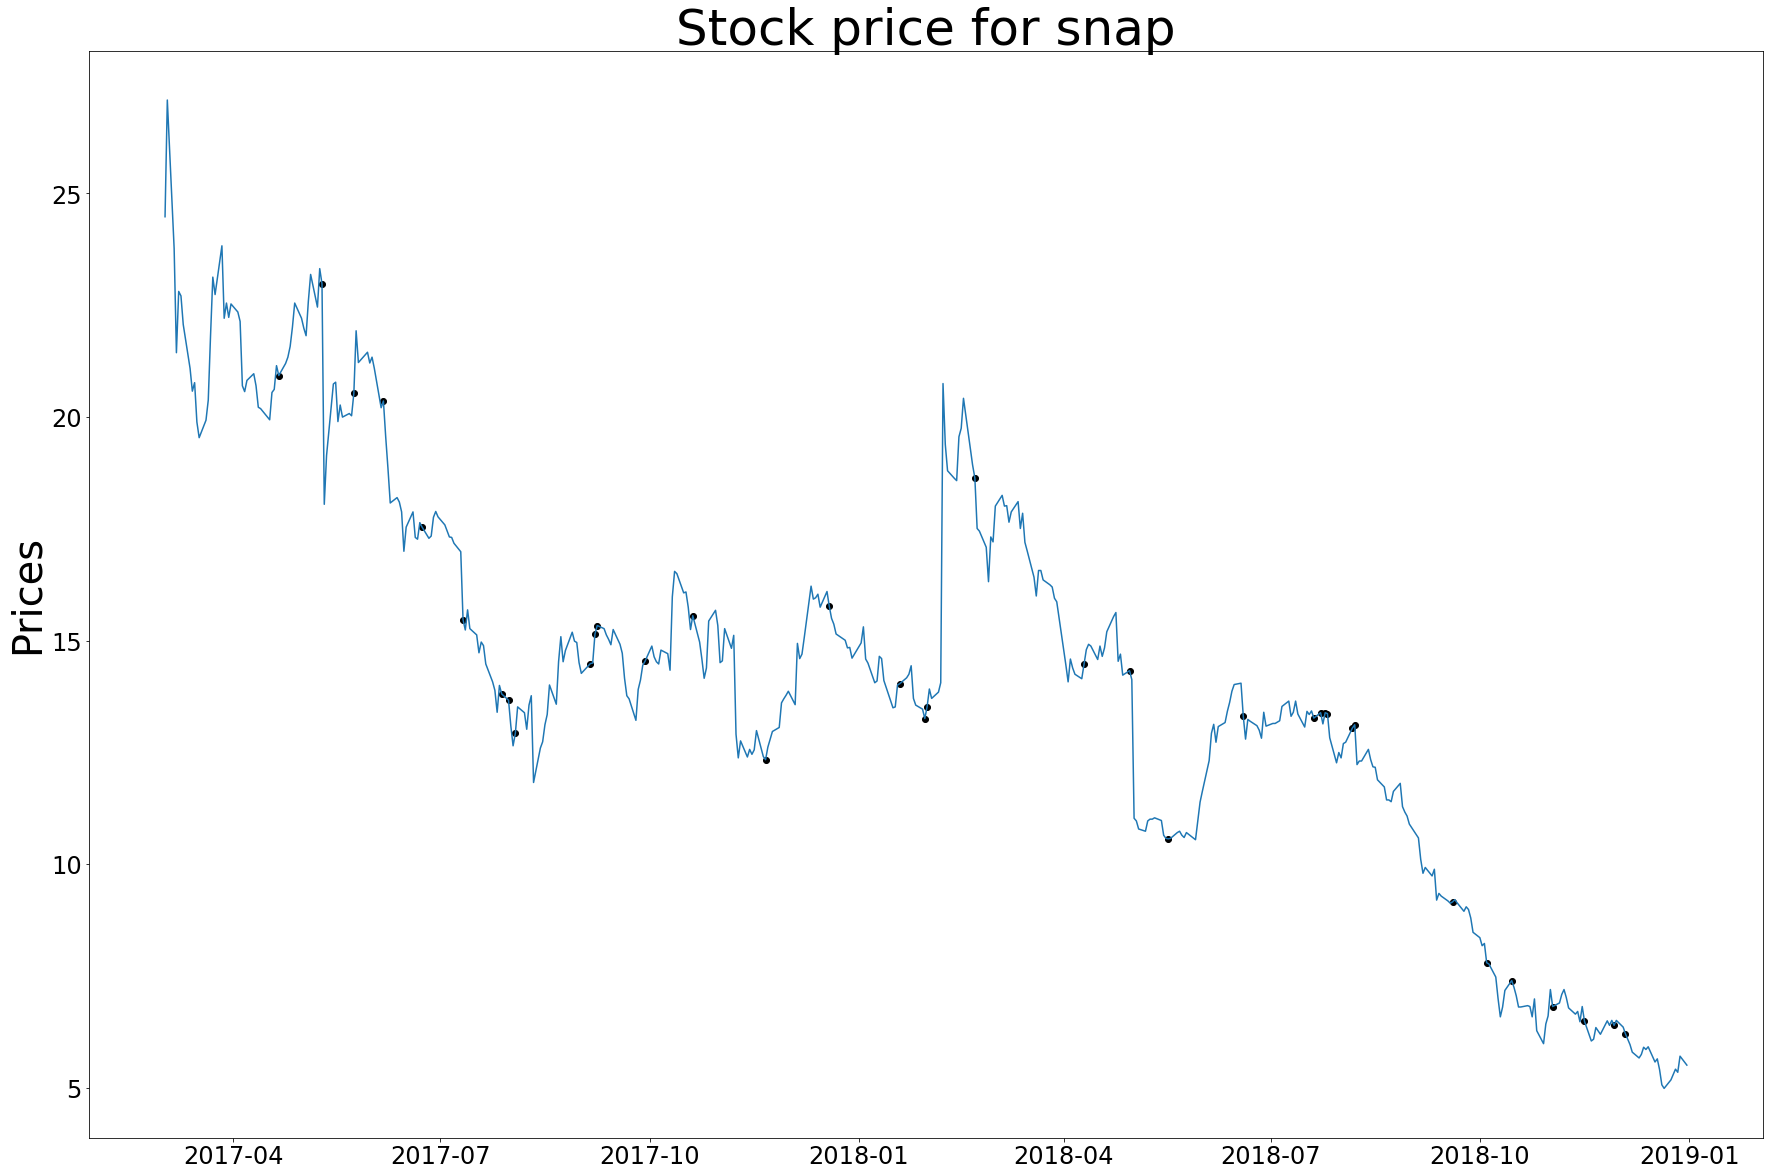

In [58]:
draw_prices_graph(prices,prices_dates, macd, signal, company_name)

In [59]:

units = 1000
capital = 0
units, capital = play_the_stock_market(units, capital, prices, macd, signal, 100)
profit = calculate_profit(units, prices[-1], prices[0], capital)
profit = round(profit, 2)*100 -100


# Wykres MACD dla danych firmy Snapchat
Gdy linia MACD przecina linie SIGNAL od dolu, jest to sygnal do sprzedazy akcji.
Gdy linia SIGNAL przecina linie MACD od dolu, jest to synal do kupna akcji.

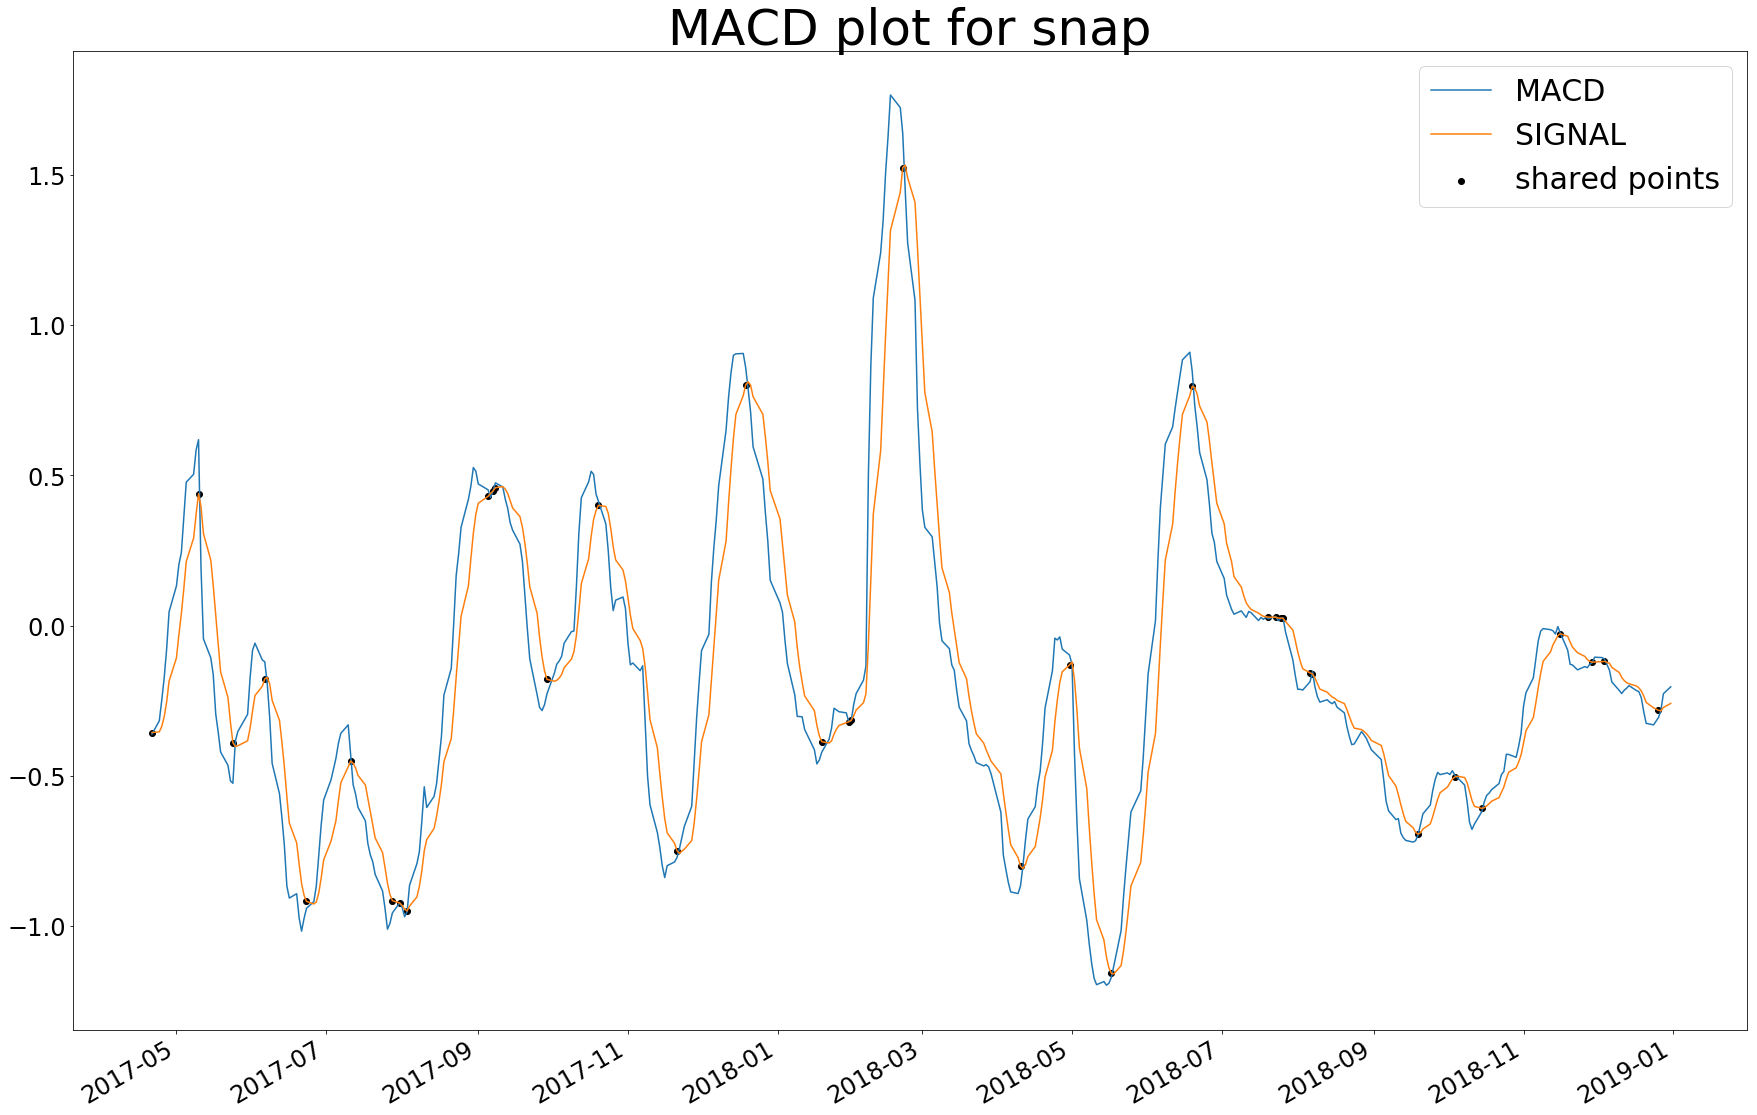

In [60]:
draw_macd_graph(macd,signal,prices_dates, company_name)

In [61]:
print("Profit percentage: " + str(profit) + "%")
print(units)
print("Start day price: " + str(prices[0]))
print("End day price: " + str(prices[-1]))

Profit percentage: -38.0%
2738
Start day price: 24.479999542236328
End day price: 5.510000228881836


# Wnioski 1
Analizujac wykresy cen akcji oraz wykres MACD, mozna dojsc do wniosku, ze w wiekszosci przypadkow wskaznik MACD prawidlowo przewiduje sytuacje na gieldzie.
Stosowanie sie do zalecen wskaznika MACD w tym przypadku spowodowalo niemalze potrojenie ilosci posiadanych jednostek, jednak cena akcji spadla kilkukrotnie, przez co w ostatecznym rozrachunku wychodzimy niekorzystnie.


# Analiza wskaznika MACD dla firmy z tendencja wzrostowa
Firma Nvidia od poczatku analizowanego okresu, az do ostatniego kwartalu 2018 roku, znacznie zyskala na wartosci.

In [52]:
company_name = 'nvda'
company_prices = download_stock_prices(company_name, 2016,1,1,2019,1,1)
company_prices = open_file_and_format(company_prices)

prices, prices_dates, macd, signal = calculate_MACD_and_SIGNAL(company_prices) 

# Wykres wartosci firmy Nvidia

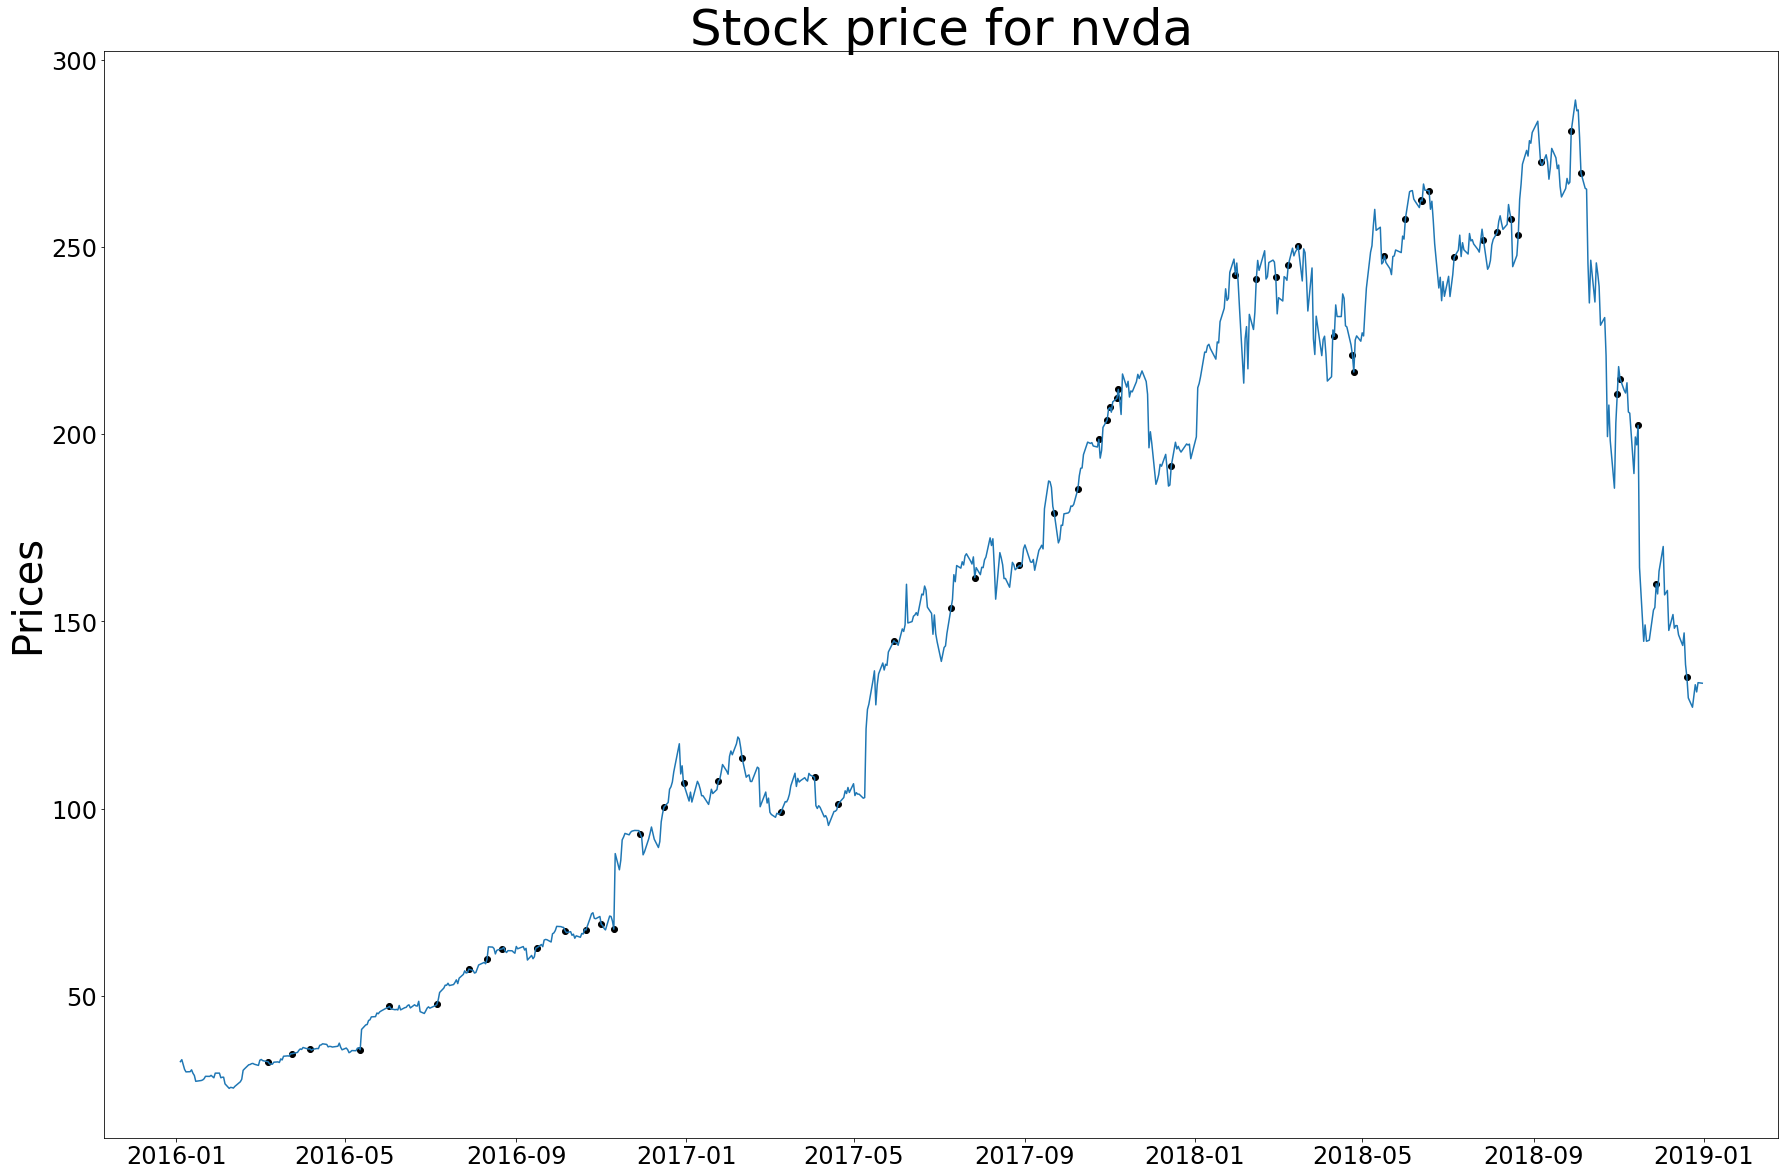

In [53]:
draw_prices_graph(prices,prices_dates, macd, signal, company_name)

In [54]:
units = 1000
capital = 0
units, capital = play_the_stock_market(units, capital, prices, macd, signal, 100)
profit = calculate_profit(units, prices[-1], prices[0], capital)
profit = round(profit, 2)*100 -100

# Wykres MACD dla danych firmy Nvidia

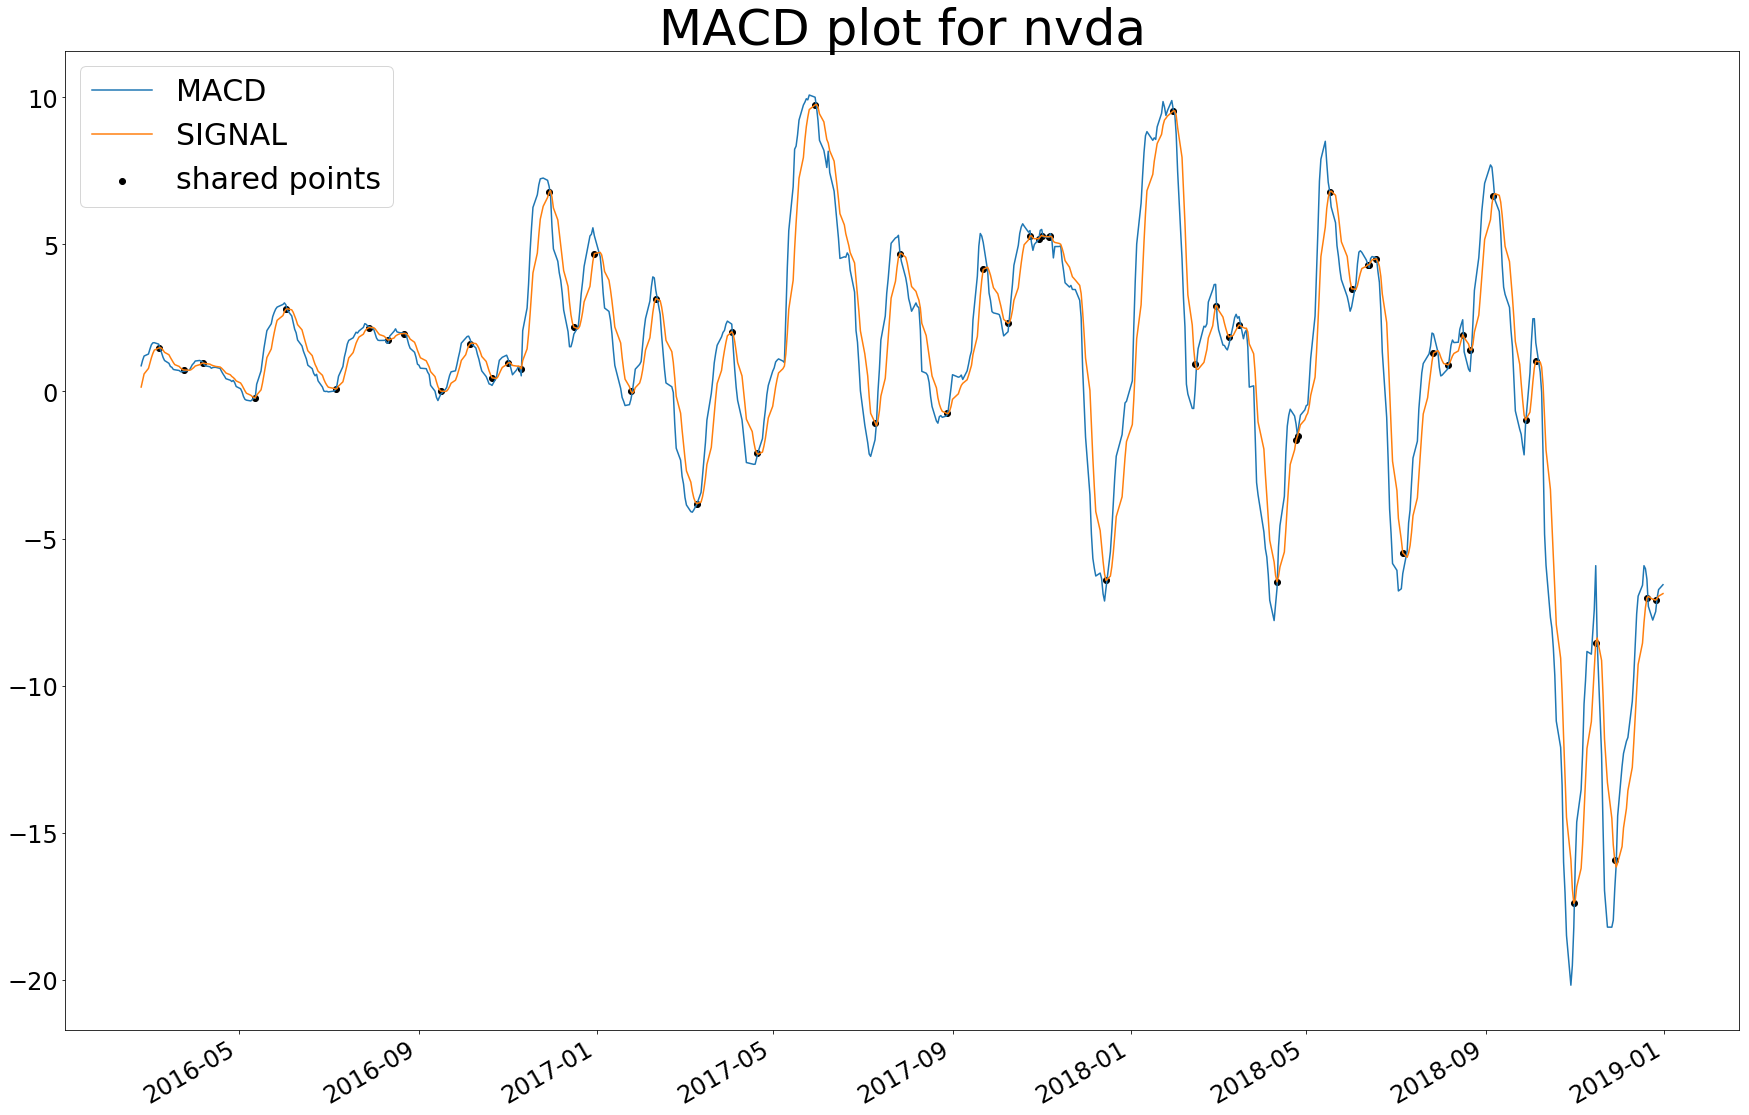

In [55]:
draw_macd_graph(macd,signal,prices_dates, company_name)

In [56]:
print("Profit percentage: " + str(profit) + "%")
print(units)
print("Start day price: " + str(prices[0]))
print("End day price: " + str(prices[-1]))

Profit percentage: 483.0%
1413
Start day price: 32.36999893188477
End day price: 133.5


# Wnioski 2
Dla firmy Nvidia, ktora przez wiekszosc badanego okresu, zyskiwala na wartosci, obserwujac wykres cen i porownywujac go z wykresem MACD, ponownie mozna odniesc wrazenie ze wskaznik prawidlowo przewidywal tendencje na gieldzie. Stosowanie sie do sugestii wskaznika MACD w tym przypadku pozwolilo znacznie zyskac.

# Wnioski koncowe
Dla obu badanych przypadkow, wskaznik MACD jest z pewnoscia bardziej skuteczny, niz losowe sprzedawanie i kupowanie akcji. Choc stosowanie go, nie zawsze przynosi zysk, pozwala on stracic mniej, niz gdyby trzymac wszystkie posiadane akcje, i sprzedac je pod koniec badanego okresu. Tak było w przypadku firmy snapchat. Jej wartosc spadla 4 krotnie, jednak strata, wyniosla tylko 38%. Dla drugiego przypadku, firmy ktora zanotowala znaczny wzrost akcji, wskaznik MACD rowniez okazal sie byc przydatny, bardziej niz  trzymanie calego kapitalu i sprzadaz go w ostatnim dniu symulacji. Udalo sie zdobyc wiecej jednostek, mimo wzrostu ceny, co jest bardzo dobrym wynikiem. Z pewnoscia nie mozna traktowac wskaznika MACD jako bezbledne narzedzie do zarabiania, jest on jednak przydatny przy grze na gieldzie.
